In [88]:
import pickle
import os
from data.pdb_utils import VOCAB
import torch
from torch_scatter import scatter_mean, scatter_sum
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import lmdb
from atom3d.datasets import LMDBDataset

from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

import prolif
from prolif.plotting.network import LigNetwork

# !!!!!!!!!!!
# Please run 'pip install -e .' in ProLIF directory to install prolif first (please use -e flag because the original code has been modified)
# !!!!!!!!!!!

# Specify Your Binding Complex of Interest & Number of Edge to Visualize & Paths

In [89]:
data_id = '8ef5_N' # pdb id
percent_edge = 0.1 # percent of all edges to show (only count edges connecting ligand and protein)
fragmentation = 'PS_300' 

# LMDB_path = 'datasets/LBA/split-by-sequence-identity-30/data/test'
processed_data_path = 'datasets/customized/customized_LBA.LBADatasetPS_300_processed.pkl'
# processed_data_path = 'datasets/LBA/split-by-sequence-identity-30/data/test.LBADataset_processed.pkl'
Shapley_value_path = f'output/{data_id}/{data_id}_statistics.txt'

# Load Ligand

[02:20:59] 7V7: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


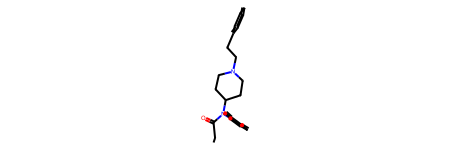

In [90]:
# load ligand data from .mol2
ligand_path = os.path.join('datasets/customized/customized_LBA/pdb_files', data_id,  data_id + '_ligand.mol2')
ligand_mol = Chem.MolFromMol2File(ligand_path, removeHs=False, sanitize=False)
ligand_mol

# Load Processed Data

In [91]:
# load data
with open(processed_data_path, 'rb') as f:
    data = pickle.load(f)

# get index and batch (binding complex) of interest
idx = [i for i, d in enumerate(data[1]) if d['id'] == data_id][0]
batch = data[2][idx]

In [92]:
# get useful data from batch
Z = torch.tensor(batch['X'])
B = torch.tensor(batch['B'])
A = torch.tensor(batch['A'])

block_lengths = torch.tensor(batch['block_lengths'])
Z = Z.reshape(Z.shape[0], 1, Z.shape[1])

# residue indices
indices = batch['indices']
list_indexes = batch['list_indexes']
residue_id = []
for b in list_indexes:
    residue_id.extend(b)
residue_id = [residue_id[i] for i in indices]

# chagne format from R_xxx to xxxR
residue_id = [f'{r[2:]}{r[0:1]}' for r in residue_id]

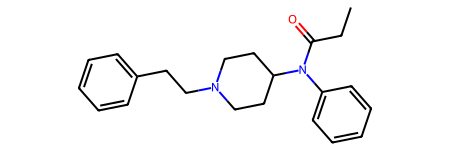

In [93]:
# get ligand
ligand_mol = batch['new_mol']
ligand_mol

In [94]:
# map fragment to atoms
frag_mol = batch['frag_mol']
frags = []
atom_idxs = []
for i in frag_mol:
    node = frag_mol.get_node(i)
    frags.append(node.smiles)
    atom_idxs.append(list(node.atom_mapping.keys()))

# for each row in atom_idxs, random choose one
atom_idxs_random_choice = [np.random.choice(i) for i in atom_idxs]

In [95]:
frags, atom_idxs

(['c1ccccc1', 'CCNC', 'CCc1ccccc1', 'CCNC(=O)CC'],
 [[21, 7, 20, 6, 5, 4],
  [23, 14, 0, 13],
  [19, 18, 17, 3, 16, 2, 15, 1],
  [22, 12, 11, 24, 10, 9, 8]])

In [96]:
# get coords of each amino acid and ligand atoms
with torch.no_grad():
    block_id = torch.zeros_like(A) # [Nu]
    block_id[torch.cumsum(block_lengths, dim=0)[:-1]] = 1
    block_id.cumsum_(dim=0)  # [Nu], block (residue) id of each unit (atom)
    
    assert Z.shape[1] == 1, "n_channel must be 1"
    top_Z = scatter_mean(Z, block_id, dim=0)  # [Nb, n_channel, 3]
B_coords = top_Z.reshape(top_Z.shape[0], top_Z.shape[2])

# coords of each amino acid and ligand atoms
B_coords.shape

torch.Size([42, 3])

In [97]:
# mol to smile
Chem.MolToSmiles(ligand_mol)

'CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1'

In [98]:
# convert indexed data to name of amino acid and ligand atoms
VOCAB.load_tokenizer(fragmentation)
B_abrv = [VOCAB.symbol_to_abrv(VOCAB.idx_to_symbol(i)) for i in B]
# replace <G> with Global
B_abrv = ['Global' if abrv == '<G>' else abrv for abrv in B_abrv]
B_abrv

# start index in B_abrv of protein and ligand atoms
protein_start_idx = 1
ligand_start_idx = B_abrv.index('Global', 1)

In [99]:
B_abrv

['Global',
 'ALA',
 'THR',
 'LEU',
 'PHE',
 'GLN',
 'ASN',
 'LEU',
 'CYS',
 'VAL',
 'ILE',
 'SER',
 'ILE',
 'ASP',
 'TYR',
 'ASN',
 'MET',
 'ASP',
 'CYS',
 'THR',
 'LEU',
 'LEU',
 'LYS',
 'VAL',
 'PHE',
 'ALA',
 'PHE',
 'TRP',
 'ILE',
 'HIS',
 'VAL',
 'CYS',
 'ILE',
 'ALA',
 'LEU',
 'GLY',
 'TYR',
 'Global',
 'c1ccccc1',
 'CCNC',
 'CCc1ccccc1',
 'CCNC(=O)CC']

In [100]:
# the amino acid start index is 1 and ligand_start_idx-1 because of the Global at begaining of amino acid and ligand

# Load Shapley Value

In [101]:
with open(Shapley_value_path, 'r') as f:
    lines = f.readlines()
    shapley_dict = {}
    for line in lines[8:]:
        node_idx1 = int(line.split(',')[0].split('(')[1])
        node_idx2 = int(line.split(',')[1].split(')')[0])
        shapley_val = float(line.split(':')[-1])
        shapley_dict[(node_idx1, node_idx2)] = shapley_val

# descending sort the shapley_dict based on shapley_val
shapley_dict = dict(sorted(shapley_dict.items(), key=lambda item: item[1], reverse=True))

In [102]:
# the amino acid start index is 1 and ligand_start_idx-1 because of the Global at begaining of amino acid and ligand
# 
# filter only edge where node1 is amino acid and node2 is ligand atoms or vice versa
shapley_dict_bridge_edge = {k: v for k, v in shapley_dict.items() if (k[0] in range(1, ligand_start_idx-1) and k[1] in range(ligand_start_idx, len(B_abrv)+1)) or (k[0] in range(ligand_start_idx, len(B_abrv)+1) and k[1] in range(1, ligand_start_idx-1))}

# Min-Max normalize shapley_dict_bridge_edge from 0 to 1
shapley_dict_bridge_edge_normalized = {k: (v - min(shapley_dict_bridge_edge.values()))/(max(shapley_dict_bridge_edge.values())-min(shapley_dict_bridge_edge.values())) for k, v in shapley_dict_bridge_edge.items()}

In [103]:
# choose top k% of the edges
num_edge = int(len(shapley_dict_bridge_edge) * percent_edge)
num_edge

14

In [104]:
# get top edges with highest shapley value
top_edges = list(shapley_dict_bridge_edge.keys())[:num_edge]
top_edges_shapley = list(shapley_dict_bridge_edge.values())[:num_edge]

# reorder each edge in top_edges, where small index is node1 and large index is node2
top_edges = [edge if edge[0] < edge[1] else (edge[1], edge[0]) for edge in top_edges]
top_edges, top_edges_shapley, B_coords.shape, len(top_edges)

([(33, 38),
  (34, 40),
  (33, 40),
  (33, 41),
  (34, 41),
  (12, 41),
  (19, 41),
  (9, 40),
  (26, 39),
  (3, 39),
  (22, 41),
  (33, 39),
  (7, 38),
  (13, 38)],
 [0.06116694211959839,
  0.048484054207801816,
  0.04274033308029175,
  0.03741006255149841,
  0.03068980574607849,
  0.02989923357963562,
  0.02338094711303711,
  0.023266807198524475,
  0.021142943203449248,
  0.021043315529823303,
  0.018934707343578338,
  0.018364107608795165,
  0.01823359876871109,
  0.01808874011039734],
 torch.Size([42, 3]),
 14)

# Visualize Using prolif

In [105]:
# a function to calculate distance between two atoms
def calc_distance(node1, node2):
    # just use euclidean distance
    return np.linalg.norm(B_coords[node1] - B_coords[node2])

In [106]:
# construct dataframe for prolif
df = pd.DataFrame(columns=["ligand", "protein", "interaction", "atoms", "weight", "distance"])

VOCAB.load_tokenizer(fragmentation)
B_abrv = [VOCAB.symbol_to_abrv(VOCAB.idx_to_symbol(i)) for i in B]
# iterate through top_20_edges. for each edge, store ligand as 1c86; then map node1 to VOCAB, store as protein; store node2 as atoms; store shapley value as weight; then using calc_distance to calculate distance, and store distance 
for i, edge in enumerate(top_edges):
    if edge[0] == ligand_start_idx-1:
        continue
    ligand = data_id
    # idx here is the idx in the B, use B[idx] to map back to amino acid or atom number
    protein = VOCAB.symbol_to_abrv(VOCAB.idx_to_symbol(B[edge[0]])) + str(residue_id[edge[0]-1])
    # atom_idx = int(edge[1]-ligand_start_idx)
    atom_idx = atom_idxs_random_choice[edge[1]-ligand_start_idx-1]
    # create a tuple with only 1 element
    atoms = (atom_idx,)
    interaction = "Shapley Value"
    weight = top_edges_shapley[i] * 30
    distance = calc_distance(edge[0], edge[1])
    df = pd.concat([df, pd.DataFrame({"ligand": ligand, "protein": protein, "interaction": interaction, "atoms": atoms, "weight": weight, "distance": distance})], ignore_index=True)

# set atoms type to tuple
df.atoms = df.atoms.apply(lambda x: (x,))

# order by protein, interaction, atoms
df.sort_values(by=["ligand", "protein", "interaction", "atoms"], inplace=True)
df.set_index(["ligand", "protein", "interaction", "atoms"], inplace=True)
df

/tmp/ipykernel_268577/3211182182.py:20: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



weight   distance
ligand protein interaction   atoms                     
8ef5_N ALA325M Shapley Value (2,)   1.282210  13.537279
                             (12,)  1.122302  10.941972
                             (14,)  0.550923  10.582809
                             (21,)  1.835008   8.119699
       ASP149M Shapley Value (21,)  0.542662   5.848743
       ILE148M Shapley Value (12,)  0.896977  12.034025
       LEU123M Shapley Value (14,)  0.631299   9.835655
       LEU141M Shapley Value (21,)  0.547008  17.965727
       LEU326M Shapley Value (2,)   1.454522  16.399618
                             (12,)  0.920694  11.512487
       LYS235M Shapley Value (12,)  0.568041   8.231711
       PHE243M Shapley Value (14,)  0.634288  15.088074
       THR220M Shapley Value (12,)  0.701428  12.681219
       VAL145M Shapley Value (2,)   0.698004   6.128331

# If edges clustered together, run the below code block again to generate another plot

In [109]:
# construct prolif network and visualize

lg = LigNetwork(df, ligand_mol)
# set color for edge
lg.COLORS['interactions']['Shapley Value'] = '#59e382'
lg.display()